In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np

from flax.core.frozen_dict import freeze, FrozenDict
from jax.flatten_util import ravel_pytree
from jax.tree_util import register_pytree_node_class
import jax.experimental.optimizers as optimizers
from tqdm.auto import tqdm
import copy

from contextlib import contextmanager

@register_pytree_node_class
class Model:
    def __init__(self, a=1.0, b=2.0, c=3.0):
        self.a = a
        self.b = b
        self.c = c
    
    @property
    def _hyperparameters(self):
        return freeze(dict(c=self.c))
    
    @_hyperparameters.setter
    def _hyperparameters(self, hyperparams):
        self.c = hyperparams["c"]
        
    @property
    def _parameters(self):
        return freeze(dict(a=self.a, b=self.b))
    
    @_parameters.setter
    def _parameters(self, params):
        self.a = params["a"]
        self.b = params["b"]
        
    def tree_flatten(self):
        children = (self._parameters, self._hyperparameters)
        aux_data = None
        return children, aux_data
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        params, hypers = children
        return cls(**params, c=hypers)
    
    @contextmanager
    def inject(self, new_parameters):
        old_parameters = copy.deepcopy(self._parameters)
        self._parameters = new_parameters
        yield self
        self._parameters = old_parameters
    
    def loss(self, data):
            return ((self.a - data[0])**2 + 
                    (self.b - data[1])**2 + 
                    (self.c - data[2])**2)        
        
    def fit(self, data):
        
        init_fn, update_fn, get_params = optimizers.adam(1e-3)
        opt_state = init_fn(self._parameters)

        # OPTION 1
        # def objective(params):
        #     self._parameters = params
        #     return self.loss(data)
        
        # OPTION 2
        def objective(params):
            with self.inject(params):
                return self.loss(data)
        
        @jax.jit
        def step(idx, opt_state):
            value, grads = jax.value_and_grad(objective)(get_params(opt_state))
            opt_state = update_fn(idx, grads, opt_state)
            return value, opt_state
        
        losses = []
        for idx in tqdm(range(10000)):
            value, opt_state = step(idx, opt_state)
            losses.append(value)
            
        self._parameters = get_params(opt_state)
        return losses

FrozenDict({
    a: 1.0,
    b: 2.0,
})


100%|██████████| 10000/10000 [00:00<00:00, 23679.75it/s]


FrozenDict({
    a: DeviceArray(4.9999785, dtype=float32),
    b: DeviceArray(9.645768, dtype=float32),
})


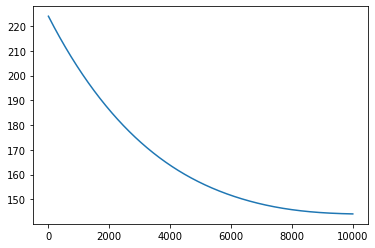

In [3]:
model = Model()

print(model._parameters)
losses = model.fit(np.array([5., 10., 15.,]))
print(model._parameters)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [4]:
@jax.jit
def identity(model):
    return model

identity(model)

In [5]:
model._parameters

FrozenDict({
    a: DeviceArray(4.9999785, dtype=float32),
    b: DeviceArray(9.645768, dtype=float32),
})

In [6]:
model._hyperparameters

FrozenDict({
    c: 3.0,
})

In [7]:
flattened, unflatten_fn = ravel_pytree(model._parameters)
print(flattened)

[4.9999785 9.645768 ]


In [8]:
model = Model()

print(model._parameters)

with model.inject(new_parameters={"a": 10., "b": 20.}):
    print("injected params in this scope: ", model._parameters)

print("old params are preserved: ", model._parameters)

FrozenDict({
    a: 1.0,
    b: 2.0,
})
injected params in this scope:  FrozenDict({
    a: 10.0,
    b: 20.0,
})
old params are preserved:  FrozenDict({
    a: 1.0,
    b: 2.0,
})


In [3]:
from ssm.hmm import GaussianHMM
import jax.random as jr

In [5]:
hmm = GaussianHMM(3, 10, seed=jr.PRNGKey(0))

print("Parameters =", hmm._parameters)

Parameters = FrozenDict({
    initial_condition: {
        distribution: {
            logits: DeviceArray([-1.0986123, -1.0986123, -1.0986123], dtype=float32),
        },
    },
    transitions: {
        distribution: {
            logits: DeviceArray([[-1.0986123, -1.0986123, -1.0986123],
                         [-1.0986123, -1.0986123, -1.0986123],
                         [-1.0986123, -1.0986123, -1.0986123]], dtype=float32),
        },
    },
    emissions: {
        distribution: {
            loc: DeviceArray([[-0.28371075,  0.9368161 , -1.0050074 ,  1.4165013 ,
                           1.05433   ,  0.9108126 , -0.42656714,  0.98618793,
                          -0.5575325 ,  0.01532494],
                         [-2.0785687 ,  0.554837  ,  0.9142364 ,  0.57445955,
                           0.72278625,  0.12106168, -0.32373545,  1.6234994 ,
                           0.24500382, -1.3809782 ],
                         [-0.6111238 ,  0.14037243,  0.8410042 , -1.094358  ,
    